In [30]:
import os
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

In [31]:
df = pd.read_csv("./Dataset/captions.txt")
df

,Image Name,Caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [32]:
img_path = './Dataset/Images/'

df['Image Name'] = img_path + df['Image Name']
df


,Image Name,Caption
0,./Dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,./Dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,./Dataset/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,./Dataset/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,./Dataset/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,./Dataset/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [33]:
# import cv2
# x = cv2.imread(df['Image Name'][100])
# cv2.imshow('Image', x)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

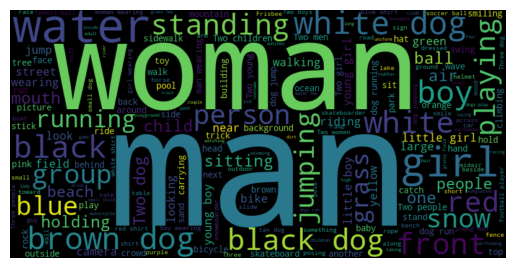

In [34]:
words = " ".join(df['Caption'].values)
wordcloud = WordCloud(width=800, height=400).generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


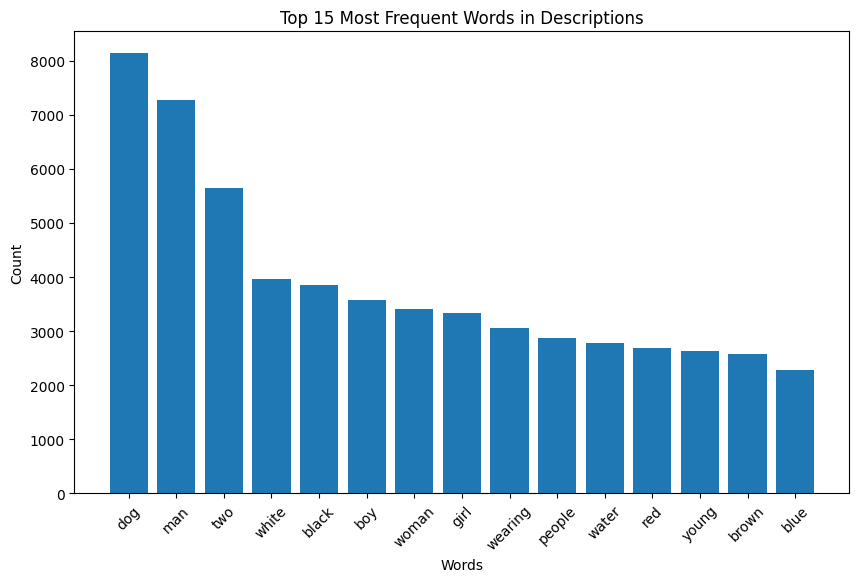

In [35]:
import nltk
nltk.download('stopwords')

# Tokenize the words in the descriptions
descriptions = " ".join(df['Caption'].values)
words = re.findall(r'\w+', descriptions.lower())  # Convert to lowercase and extract words

# Remove stopwords (like 'the', 'and', etc.)
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the 15 most common words
most_common_words = word_counts.most_common(15)

# Separate the words and their counts
words, counts = zip(*most_common_words)

# Plot a bar chart of the most frequent words
plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.title('Top 15 Most Frequent Words in Descriptions')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Model Building

In [36]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [37]:
df = df[:200]
df


,Image Name,Caption
0,./Dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,./Dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
195,./Dataset/Images/1055623002_8195a43714.jpg,A group of four children wearing pajamas have ...
196,./Dataset/Images/1055623002_8195a43714.jpg,A group of kids have a pillow-fight .
197,./Dataset/Images/1055623002_8195a43714.jpg,A group of young children playing pillow fight...
198,./Dataset/Images/1055623002_8195a43714.jpg,Children having a pillow fight .


In [38]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from collections import Counter

def preprocess_captions(captions, max_len=20):
    """
    Preprocesses the captions: tokenizes, creates vocabulary, and pads the captions to a fixed length.
    
    Args:
        captions (list): List of caption strings.
        max_len (int): Maximum length of captions (after padding).
    
    Returns:
        padded_captions (torch.Tensor): Padded caption sequences as tensors.
        vocab (dict): Vocabulary mapping words to integer indices.
        reverse_vocab (dict): Reverse mapping from indices to words.
    """
    # Tokenize captions
    tokenized_captions = [caption.split() for caption in captions]

    # Create vocabulary (word to index mapping)
    vocab = Counter(word for caption in tokenized_captions for word in caption)
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(vocab.items())}  # Index +1 to reserve 0 for padding
    vocab_size = len(vocab) + 1  # Add 1 for padding

    # Create a reverse vocabulary for decoding
    reverse_vocab = {idx: word for word, idx in vocab.items()}

    # Convert each caption to a list of word indices
    indexed_captions = [[vocab.get(word, 0) for word in caption] for caption in tokenized_captions]

    # Pad sequences to max_len (truncate if longer)
    padded_captions = [caption[:max_len] + [0] * (max_len - len(caption)) if len(caption) < max_len else caption[:max_len] for caption in indexed_captions]

    # Convert to tensor
    captions_tensor = torch.tensor(padded_captions)

    return captions_tensor, vocab, reverse_vocab

captions = df['Caption'].tolist()

# Preprocess captions
max_len = 20
padded_captions, vocab, reverse_vocab = preprocess_captions(captions, max_len)


# Define Dataset
class Flickr8kDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, vocab=None, max_len=20):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        caption = self.dataframe.iloc[idx, 1]
        
        # Tokenize and pad the caption
        tokenized_caption = caption.split()
        indexed_caption = [self.vocab.get(word, 0) for word in tokenized_caption]  # 0 is for unknown words
        padded_caption = indexed_caption[:self.max_len] + [0] * (self.max_len - len(indexed_caption))
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(padded_caption)

# Image Encoder using Pretrained ResNet
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False  # Freeze resnet
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove last fc layer
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.fc(features))
        return features

# Caption Decoder using LSTM
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.fc(hiddens)
        return outputs

# Hyperparameters
embed_size = 256
hidden_size = 512
vocab_size = 10000  # Adjust based on your vocabulary size
num_layers = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader
df = df  # Your dataframe
img_dir = ""
dataset = Flickr8kDataset(df, img_dir, transform=transform, vocab=vocab, max_len=20)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure the model is on the same device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Training loop
for epoch in range(num_epochs):
    for i, (images, captions) in enumerate(dataloader):
        # Prepare input
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1])  # Ignore <end> token during training
        
        # # Print shapes for debugging
        # print(f'Outputs shape: {outputs.shape}')  # Should be [batch_size, seq_len, vocab_size]
        # print(f'Captions shape: {captions.shape}')  # Should be [batch_size, seq_len]
        
        # Reshape the outputs and captions
        outputs_reshaped = outputs.view(-1, vocab_size)  # Flatten the output tensor: [batch_size * seq_len, vocab_size]
        captions_reshaped = captions[:, :].reshape(-1)  # Ignore <start> token and reshape: [batch_size * seq_len]

        # # Print reshaped dimensions
        # print(f'Outputs reshaped shape: {outputs_reshaped.shape}')
        # print(f'Captions reshaped shape: {captions_reshaped.shape}')

        # loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))  # Ignore <start>
        loss = criterion(outputs_reshaped, captions_reshaped)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')


c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Step [1/7], Loss: 9.1742
Epoch [2/10], Step [1/7], Loss: 5.7153
Epoch [3/10], Step [1/7], Loss: 4.1878
Epoch [4/10], Step [1/7], Loss: 3.4235
Epoch [5/10], Step [1/7], Loss: 2.9980
Epoch [6/10], Step [1/7], Loss: 2.9146
Epoch [7/10], Step [1/7], Loss: 2.6711
Epoch [8/10], Step [1/7], Loss: 2.4988
Epoch [9/10], Step [1/7], Loss: 2.3153
Epoch [10/10], Step [1/7], Loss: 2.1649


Prediction

In [39]:
import re
from collections import Counter

def build_vocab(captions, max_vocab_size=None):
    """
    Build vocabulary from captions.
    Args:
    - captions: List of string captions.
    - max_vocab_size: Limit the size of the vocabulary.
    
    Returns:
    - vocab: A dictionary mapping words to indices.
    - reverse_vocab: A dictionary mapping indices to words.
    """
    # Tokenize captions (you can adjust this for better tokenization)
    all_words = []
    for caption in captions:
        tokens = re.findall(r'\w+', caption.lower())  # Tokenize words and make lowercase
        all_words.extend(tokens)
    
    # Create a frequency dictionary of words
    word_counts = Counter(all_words)
    
    # Create a vocab dictionary with special tokens <start>, <end>
    vocab = {'<start>': 1, '<end>': 2, '<pad>': 0, '<unk>': 3}  # Index for padding, unknown words, start, end
    index = 4  # Start assigning indices from 4 (since 0-3 are reserved for special tokens)
    
    # Add words to vocab (sorted by frequency)
    for word, _ in word_counts.most_common(max_vocab_size):
        vocab[word] = index
        index += 1
    
    # Reverse vocab for decoding
    reverse_vocab = {index: word for word, index in vocab.items()}
    
    return vocab, reverse_vocab

# Example usage
captions = list(df.Caption)

vocab, reverse_vocab = build_vocab(captions)
print("Vocabulary:", vocab)
print("Reverse Vocabulary:", reverse_vocab)


Vocabulary: {'<start>': 1, '<end>': 2, '<pad>': 0, '<unk>': 3, 'a': 4, 'the': 5, 'in': 6, 'dog': 7, 'on': 8, 'with': 9, 'of': 10, 'man': 11, 'is': 12, 'and': 13, 'black': 14, 'white': 15, 'to': 16, 'boy': 17, 'at': 18, 'front': 19, 'girl': 20, 'are': 21, 'water': 22, 'an': 23, 'two': 24, 'young': 25, 'ice': 26, 'brown': 27, 'people': 28, 'grass': 29, 'while': 30, 'red': 31, 'running': 32, 'blue': 33, 'child': 34, 'playing': 35, 'dogs': 36, 'sitting': 37, 'beach': 38, 'climbing': 39, 'little': 40, 'his': 41, 'through': 42, 'snow': 43, 'toy': 44, 'by': 45, 'green': 46, 'yellow': 47, 'woman': 48, 'ball': 49, 'wall': 50, 'over': 51, 'person': 52, 'three': 53, 'sits': 54, 'large': 55, 'next': 56, 'near': 57, 'another': 58, 'up': 59, 'outside': 60, 'hat': 61, 'standing': 62, 'field': 63, 'group': 64, 'catch': 65, 'mouth': 66, 'lake': 67, 'into': 68, 'it': 69, 'pigtails': 70, 'wearing': 71, 'rock': 72, 'watches': 73, 'couple': 74, 'building': 75, 'street': 76, 'looking': 77, 'small': 78, 'pla

In [41]:
import torch
from torchvision import transforms
from PIL import Image

# Function to load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict the caption for an image
def predict_caption(image_path, encoder, decoder, vocab, max_length=20):
    # Load and preprocess the image (use the same preprocessing as during training)
    image = preprocess_image(image_path).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Get image features from the encoder
    features = encoder(image)
    
    # Flatten features or pool the spatial dimensions to match the sequence size
    features = features.view(features.size(0), -1)  # Flatten the features to [batch_size, feature_dim]
    
    # Start the caption with the <start> token
    caption = [vocab['<start>']]
    
    # Predict the next tokens one by one
    for _ in range(max_length):
        # Convert the caption to a tensor and predict the next token
        inputs = torch.tensor(caption).unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        # Concatenate image features with word embeddings
        embeddings = decoder.embed(inputs)  # Assuming decoder has an embedding layer
        
        # If the features are 2D and embeddings are 3D, unsqueeze the features to match
        features_unsqueezed = features.unsqueeze(1)  # Reshape to [batch_size, 1, feature_dim]
        embeddings = torch.cat((features_unsqueezed, embeddings), dim=1)  # Concatenate along the sequence dimension
        
        # Pass through the decoder
        outputs = decoder(embeddings)
        predicted = outputs.argmax(dim=2)[:, -1].item()  # Get the token with highest probability
        
        # Stop if <end> token is predicted
        if predicted == vocab['<end>']:
            break
        
        # Add predicted token to the caption
        caption.append(predicted)
    
    # Convert the token indices back to words
    predicted_caption = [reverse_vocab[idx] for idx in caption if idx not in [vocab['<start>'], vocab['<end>']]]
    return ' '.join(predicted_caption)

# Example usage
image_path = './Dataset/Images/140526327_3cb984de09.jpg'
predicted_caption = predict_caption(image_path, encoder, decoder, vocab)
print(f'Predicted Caption: {predicted_caption}')


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 256, 256]